# 2024 COMP90042 Project
*Make sure you change the file name with your group id.*

# Readme
All code for generating the pickle files used in this notebook are included. For more details, please see the OOP section.

In [1]:
#imports
from gensim.utils import deaccent
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


from sklearn.metrics import classification_report
from collections import Counter
import re

import pandas as pd

import pickle
import seaborn as sns
import torch
import contractions

import matplotlib.pyplot as plt
import torchtext
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


/Users/kaiyuancui/opt/anaconda3/lib/python3.9/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/kaiyuancui/opt/anaconda3/lib/python3.9/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Users/kaiyuancui/opt/anaconda3/lib/python3.9/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT

True

# 1.DataSet Processing
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [2]:

nltk.download('averaged_perceptron_tagger')

#d_evidence = pd.read_json("data/evidence.json", typ='series')

lemmatizer = WordNetLemmatizer()

# contraction_dict from WS7
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}




# https://stackoverflow.com/a/46231553
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 
    
def sentence_preprocessing(sentence):

    out_list = []
    # Use gensim deaccent to match more characters to [a-z]
    sentence = deaccent(sentence.lower())

    for old, new in contraction_dict.items():
        sentence.replace(old, new)

    tokenized = word_tokenize(sentence)

    # now remove all tokens that don't contain any alphanumeric characters
    # then strip non alphanumeric characters afterwards
    tokenized = [re.sub(r"[^a-z0-9\s]", "", token) for token in tokenized if re.match(r"[a-z0-9\s]", token)]

    # now lemmatize with pos
    tagged = pos_tag(tokenized)
    for token, tag in tagged:
        wntag = get_wordnet_pos(tag)

        if wntag is None: # do not supply tag in case of None
            lemma = lemmatizer.lemmatize(token) 
        else:
            lemma = lemmatizer.lemmatize(token, pos=wntag) 

        out_list.append(lemma)
    
    return out_list


# https://huggingface.co/learn/nlp-course/chapter6/6
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

# adapted from https://huggingface.co/learn/nlp-course/chapter6/6
def tokenize(sentence):

    # janky workaround for preprocessed sentences
    if type(sentence) is not list:
        sentence = sentence_preprocessing(sentence)
        
    encoded_words = [encode_word(word) for word in sentence]
    return sum(encoded_words, [])



with open("../pipeline/BPETokenizer_merge_rules_v1.5.pkl", "rb") as f:
    merge_rules = pickle.load(f)
    

# Reconstruct vocab from merge rules due to lack of foresight
# This grabs all vocab of length 2 or above (if contains first letter)
# or 4 or above (##__)
vocab = [v for v in merge_rules.values()]

# So iterate through merge rules again to find starting letters
# and one letter suffixes
for pair, merge in merge_rules.items():
    if len(pair[0]) == 1 and pair[0] not in vocab:
        vocab.append(pair[0])
    if len(pair[1]) == 3 and pair[1] not in vocab:
        vocab.append(pair[1])


def processed_evidence_to_bpe(paragraph):
    # 2d array -> paragraph
    if type(paragraph[0]) is list:
        return [tokenize(sentence) for sentence in paragraph]

    # 1 sentence -> tokenize as is 
    else:
        return tokenize(paragraph)


counter = 0
def processed_evidence_to_bpe(paragraph):
    global counter
    counter += 1
    if counter % 1000 == 0:
        print(f"{counter} rows processed")
    #2d array -> paragraph
    if type(paragraph[0]) is list:
        return [tokenize(sentence) for sentence in paragraph]

    # 1 sentence -> tokenize as is 
    else:
        return tokenize(paragraph)


# Save

"""
evidence["bpe evidence"] = evidence["processed evidence"].apply(processed_evidence_to_bpe)
with open("BPETokenized_evidence_v3.pkl", "wb") as f:
    pickle.dump(e, f)
"""

# Load
with open("../pipeline/BPETokenized_evidence_v3.pkl", "rb") as f:
    evidence = pickle.load(f)

"""
sentences = []

for paragraph in evidence["bpe evidence"]:
    if type(paragraph[0]) is list:
        for sentence in paragraph:
            sentences.append(sentence)
    else:
        sentences.append(paragraph)
"""

# Now do word2vec
from gensim.models import Word2Vec


EMBEDDING_DIM = 200
"""
embedding_model = Word2Vec(sentences=sentences,
                           vector_size=EMBEDDING_DIM,
                           window=4,
                           min_count=3,
                           workers=10,
                           negative=5
                           )

version = 3
with open(f"BPE Tokenizer to embedding/embeddings_BPE_v{version}.pkl", "wb") as f:
    pickle.dump(embedding_model, f)
"""

# Load embedding
with open("../pipeline/embeddings_BPE_v3.pkl", "rb") as f:
    embedding_model = pickle.load(f)

import numpy as np
def sentence_embedding(sentence):

  # Failsafe
  if len(sentence) == 0:
    return np.zeros(EMBEDDING_DIM)

  if type(sentence[0]) is not list:
      sentence = tokenize(sentence)

  # Check again here as sentence list can be empty after tokenisation (e.g. sentence = '  ')
  if len(sentence) == 0:
    return np.zeros(EMBEDDING_DIM)


  embedding = np.zeros(EMBEDDING_DIM)
  for word in sentence:
    word_embedding = np.zeros(EMBEDDING_DIM)

    # get word vector for given word
    # if not found, ignore (treat as having the zero vector)
    try:
      word_embedding = embedding_model.wv[str(word)]
    except KeyError:
      pass

    embedding += word_embedding

  return embedding / len(sentence)


def paragraph_embedding(paragraph):
    out = []

    # One sentence
    if type(paragraph[0]) is not list:
        return [sentence_embedding(paragraph)]

    else:
        for sentence in paragraph:
            out.append(sentence_embedding(sentence))
    return out

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kaiyuancui/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Baseline retrieval: immediately use the raw embeddings to retrieve closest sentences
# Train a cutoff distance threshold.


# Similarity based on cosine similarity ([0-1], higher the more similar)
def similarity(text, evidence_ids):

    # Seems stupid and retrieving everything from w2v is probably cleaner
    # TODO: make this better
    evidence_embeddings = [evidence.loc[evidence['id'] == id, 'embeddings'].values[0] for id in evidence_ids]
    key_embedding = sentence_embedding(text)
    
    similarities = []
    for evidence_embedding in evidence_embeddings:
        similarities.append(1-cosine(key_embedding, evidence_embedding))

    return similarities


# Using 1 - fscore as the loss
def retrieval_loss(prediction, target):
    numerator = 0
    denominator = 0
    
    for p in prediction:
        if p in target:
            denominator += 2
            numerator += 2
        else:
            denominator += 1
    
    for t in target:
        if t not in prediction:
            denominator += 1
    
    return 1 - numerator/denominator

In [4]:
#visualising training data
train = pd.read_json("../data/train-claims.json") # for local dev
train = train.transpose()
train.head()


,claim_text,claim_label,evidences
claim-1937,Not only is there no scientific evidence that ...,DISPUTED,"[evidence-442946, evidence-1194317, evidence-1..."
claim-126,El Niño drove record highs in global temperatu...,REFUTES,"[evidence-338219, evidence-1127398]"
claim-2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,"[evidence-530063, evidence-984887]"
claim-2021,Weather Channel co-founder John Coleman provid...,DISPUTED,"[evidence-1177431, evidence-782448, evidence-5..."
claim-2449,"""January 2008 capped a 12 month period of glob...",NOT_ENOUGH_INFO,"[evidence-1010750, evidence-91661, evidence-72..."


In [5]:

test = pd.read_json("../data/test-claims-unlabelled.json") # for local dev
dev_data = pd.read_json("../data/dev-claims.json")
test = test.transpose()
dev_data = dev_data.transpose()
test.head()

dev_data.head()


,claim_text,claim_label,evidences
claim-752,[South Australia] has the most expensive elect...,SUPPORTS,"[evidence-67732, evidence-572512]"
claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,"[evidence-996421, evidence-1080858, evidence-2..."
claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,"[evidence-889933, evidence-694262]"
claim-871,"“As it happens, Zika may also be a good model ...",NOT_ENOUGH_INFO,"[evidence-422399, evidence-702226, evidence-28..."
claim-2164,Greenland has only lost a tiny fraction of its...,REFUTES,"[evidence-52981, evidence-264761, evidence-947..."


In [6]:
#visualising evidence data

evidence = pd.read_json("../data/evidence.json",typ='series')
print(len(evidence))
evidence.head()

1208827


evidence-0    John Bennet Lawes, English entrepreneur and ag...
evidence-1    Lindberg began his professional career at the ...
evidence-2    ``Boston (Ladies of Cambridge)'' by Vampire We...
evidence-3    Gerald Francis Goyer (born October 20, 1936) w...
evidence-4    He detected abnormalities of oxytocinergic fun...
dtype: object

In [7]:
def preprocess_data(data: pd.Series) -> pd.Series:
  preprocessed_data = {}
  stop_words = set(stopwords.words('english'))
  stop_words.remove('not')
  for id, text in data.items():
    text = text.lower()
    text = contractions.fix(text)
    tokens = word_tokenize(text)
    wnl = WordNetLemmatizer()
    lemmatized_tokens = [wnl.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    preprocessed_data[id] = " ".join(lemmatized_tokens)

  return pd.Series(preprocessed_data)


train_claims = train['claim_text']
test_claims = test['claim_text']
dev_claims = dev_data['claim_text']
processed_evidence = preprocess_data(evidence)
processed_test = preprocess_data(test_claims)
processed_dev = preprocess_data(dev_claims)
print(len(processed_evidence))
processed_train_claim = preprocess_data(train_claims)
processed_dev_claim = preprocess_data(dev_claims)
processed_test.head()

1208827


claim-2967               contribution waste heat global climate
claim-979     warm weather worsened recent drought included ...
claim-1609                greenland lost tiny fraction ice mass
claim-1020    global reef crisis not necessarily mean extinc...
claim-2599     small amount active substance cause large effect
dtype: object

In [8]:
processed_evidence = processed_evidence[processed_evidence.str.strip().str.len() > 0]
print(processed_evidence.head())
len(processed_evidence)

evidence-0    john bennet lawes english entrepreneur agricul...
evidence-1    lindberg began professional career age eventua...
evidence-2                boston lady cambridge vampire weekend
evidence-3    gerald francis goyer born october professional...
evidence-4    detected abnormality oxytocinergic function sc...
dtype: object


1207974

In [9]:
# testing:
evidence_embeddings = np.array([sentence_embedding(' ') for sentence in processed_evidence[:1000]])
print(evidence_embeddings)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
# Try to use the model on unseen test claims:
# Get all evidences that are likely to be relevant using a similarity score

# Vectorizing preprocessed text
# TODO: replace Tfidf with contextual embedding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

USE_EMBEDDING = False

vectorizer = TfidfVectorizer()
all_texts = pd.concat([processed_evidence, processed_train_claim])
vectorizer.fit(all_texts)

if not USE_EMBEDDING:
    evidence_tfidf = vectorizer.transform(processed_evidence)
    test_tfidf = vectorizer.transform(processed_test)
    train_tfidf = vectorizer.transform(processed_train_claim)
    dev_tfidf = vectorizer.transform(processed_dev)

    # TODO: replace with embeddings:
    similarity_matrix = cosine_similarity(test_tfidf, evidence_tfidf)
    dev_similarity_matrix = cosine_similarity(dev_tfidf, evidence_tfidf)
    train_similarity_matrix = cosine_similarity(train_tfidf, evidence_tfidf)
else:

    evidence_embeddings = np.array([sentence_embedding(sentence) for sentence in processed_evidence])
    test_embeddings = np.array([sentence_embedding(sentence) for sentence in processed_test])
    train_embeddings = np.array([sentence_embedding(sentence) for sentence in processed_train_claim])
    dev_embeddings = np.array([sentence_embedding(sentence) for sentence in processed_dev])

    similarity_matrix = cosine_similarity(test_embeddings, evidence_embeddings)
    dev_similarity_matrix = cosine_similarity(dev_embeddings, evidence_embeddings)
    train_similarity_matrix = cosine_similarity(train_embeddings, evidence_embeddings)




In [11]:
TOP_N_TRAIN = 10
TOP_N_TEST = 10

def getTopN(similarity_matrix, test, evidence, n):
    test = test.to_frame(name='claim_text')
    top_indices = np.argsort(-similarity_matrix, axis = 1)[:, :n]
    top_evidence = [[str(evidence.index[i]) for i in row] for row in top_indices]
    test['evidences'] = top_evidence

    
    return test

test_with_evi = getTopN(similarity_matrix, processed_test, processed_evidence, TOP_N_TRAIN)
test_with_evi.head()

dev_with_evi = getTopN(dev_similarity_matrix, processed_dev, processed_evidence, TOP_N_TRAIN)
train_with_evi = getTopN(train_similarity_matrix, processed_train_claim, processed_evidence, TOP_N_TRAIN)


In [12]:
# Get evidence with different values of N

TOP_N_VALUES = [5, 10, 20, 50, 100, 200]  # Values of N to iterate over
top_train_results = {n: getTopN(train_similarity_matrix, processed_train_claim, processed_evidence, n) for n in TOP_N_VALUES}

{5: {'true_evidence_count': 4122, 'true_evidence_found': 411, 'unrelated_evidence_found': 5729, 'claims_with_all_evidence': 31}, 10: {'true_evidence_count': 4122, 'true_evidence_found': 585, 'unrelated_evidence_found': 11695, 'claims_with_all_evidence': 58}, 20: {'true_evidence_count': 4122, 'true_evidence_found': 780, 'unrelated_evidence_found': 23780, 'claims_with_all_evidence': 83}, 50: {'true_evidence_count': 4122, 'true_evidence_found': 1087, 'unrelated_evidence_found': 60313, 'claims_with_all_evidence': 143}, 100: {'true_evidence_count': 4122, 'true_evidence_found': 1355, 'unrelated_evidence_found': 121445, 'claims_with_all_evidence': 192}, 200: {'true_evidence_count': 4122, 'true_evidence_found': 1687, 'unrelated_evidence_found': 243913, 'claims_with_all_evidence': 253}}
1228
83


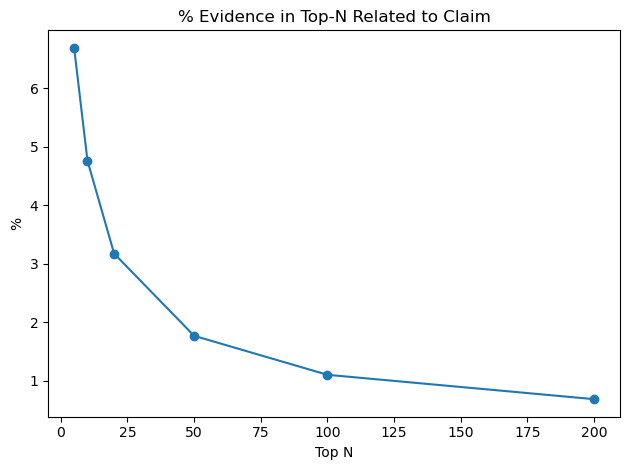

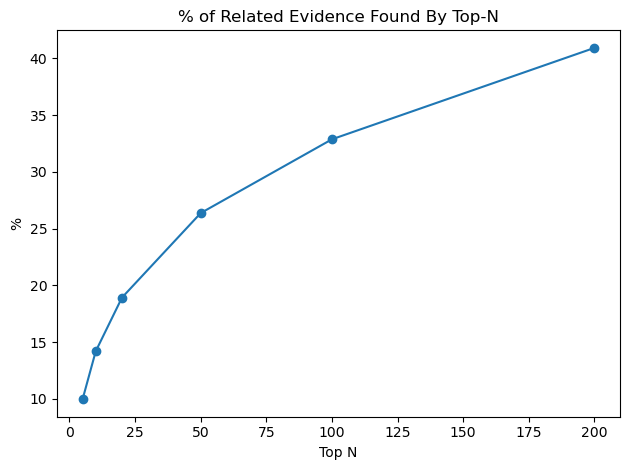

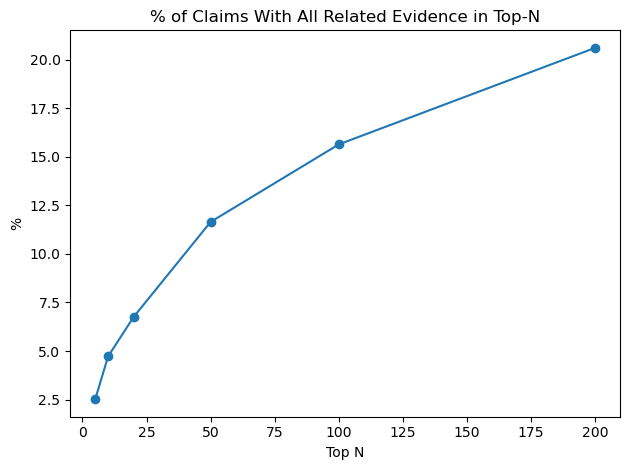

In [13]:


# check effect of N on the list of evidence found


def evaluate_top_n(similar_claim_evidence, true_claim_evidence, top_n):
    # Dictionary to store analysis results
    analysis_results = {
        'true_evidence_count': 0,
        'true_evidence_found': 0,
        'unrelated_evidence_found': 0,
        'claims_with_all_evidence': 0
    }

    for index, row in true_claim_evidence.iterrows():
        if index in similar_claim_evidence.index:
            similar_claim_evidence_row = similar_claim_evidence.loc[index]
        else:
            print(f"{index} NOT FOUND IN TOP N EVIDENCE!")
            print(similar_claim_evidence.index)
            continue
        
        true_evidence_list = row['evidences']
        similar_evidence_list = similar_claim_evidence_row['evidences']
        false_evidence_list = list(set(similar_evidence_list) - set(true_evidence_list))

        analysis_results['true_evidence_count'] += len(true_evidence_list)
        analysis_results['unrelated_evidence_found'] += len(false_evidence_list)
        analysis_results['true_evidence_found'] += len(similar_evidence_list) - len(false_evidence_list)
        
        if len(similar_evidence_list) - len(false_evidence_list) == len(true_evidence_list):
            analysis_results['claims_with_all_evidence'] += 1

    return analysis_results


evaluation_results = {n: evaluate_top_n(top_train_results[n], train, n) for n in TOP_N_VALUES}

print(evaluation_results)

evidence_found_percentage = [evaluation_results[n]['true_evidence_found'] / evaluation_results[n]['true_evidence_count'] *100 for n in TOP_N_VALUES]

related_ratio = [evaluation_results[n]['true_evidence_found'] / (evaluation_results[n]['unrelated_evidence_found'] + evaluation_results[n]['true_evidence_found'] )  * 100 for n in TOP_N_VALUES]

claims_with_all_evidence_percentage = [evaluation_results[n]['claims_with_all_evidence'] / len(processed_train_claim) *100 for n in TOP_N_VALUES]
print(len(processed_train_claim))
print(evaluation_results[20]['claims_with_all_evidence'])


plt.plot(TOP_N_VALUES, related_ratio, marker='o')
plt.title('% Evidence in Top-N Related to Claim')
plt.xlabel('Top N')
plt.ylabel('%')
plt.tight_layout()
plt.show()


plt.plot(TOP_N_VALUES, evidence_found_percentage, marker='o')
plt.title('% of Related Evidence Found By Top-N')
plt.xlabel('Top N')
plt.ylabel('%')
plt.tight_layout()
plt.show()

plt.plot(TOP_N_VALUES, claims_with_all_evidence_percentage, marker='o')
plt.title('% of Claims With All Related Evidence in Top-N')
plt.xlabel('Top N')
plt.ylabel('%')


plt.tight_layout()
plt.show()

In [14]:
# format data for the transformer

SPECIAL_TOKEN = ' <SPE_TOKEN> '

def format_for_transformer(processed_evidence, similar_claim_evidence, true_claim_evidence, top_n):
    text_lst = []
    label_lst = []

    # for analysing:
    true_evidence_num = 0
    found_evidence_num = 0
    false_evidence_num = 0
    claims_with_all_evidence = 0

    for index, row in true_claim_evidence.iterrows():
        #print(index)
        if index in similar_claim_evidence.index:
            similar_claim_evidence_row = similar_claim_evidence.loc[index]
            
        else:
            print(index + " NOT FOUND IN TOP N EVIDENCE!")
            print(similar_claim_evidence.index)
            continue
        claim_text = row['claim_text']
        
        true_evidence_list = row['evidences']
        #print(len(true_evidence_list))
        similar_evidence_list = similar_claim_evidence_row['evidences']
        false_evidence_list =  list(set(similar_evidence_list) - set(true_evidence_list))


        true_evidence_num += len(true_evidence_list)
        false_evidence_num += len(false_evidence_list)
        found_evidence_num += len(similar_evidence_list) - len(false_evidence_list)
        
        if(len(similar_evidence_list) - len(false_evidence_list) == len(true_evidence_list)):
            claims_with_all_evidence +=1    

       # print(len(false_evidence_list))
        for evidence in true_evidence_list:
            if evidence not in processed_evidence.index:
                print(evidence + "may be empty/ not in english, skipping..")
                continue
            evidence_text = processed_evidence[evidence]
            text = claim_text + SPECIAL_TOKEN + evidence_text
            text_lst.append(text)
            label_lst.append('related')
        for evidence in false_evidence_list[:top_n-len(true_evidence_list)]:
            if evidence not in processed_evidence.index:
                print(evidence + "may be empty/ not in english, skipping..")
                continue
            evidence_text = processed_evidence[evidence]
            text = claim_text + SPECIAL_TOKEN + evidence_text
            text_lst.append(text)
            label_lst.append('unrelated')


    claim_evi_label = {'text': text_lst, 'label': label_lst}

    print(f"true evidence count {true_evidence_num}")
    print(f"true evidence found in top {top_n}: {found_evidence_num}")
    print(f"unrelated evidence found in top {top_n}: {false_evidence_num}")
    print(f"# claims with all evidence in top {top_n}: {claims_with_all_evidence}")
    return pd.DataFrame(claim_evi_label)

preparedTrain = format_for_transformer(processed_evidence, train_with_evi, train, TOP_N_TRAIN)
preparedDev= format_for_transformer(processed_evidence, dev_with_evi, dev_data, TOP_N_TEST)
# preparedTrain = prepareTrainData(10)
# preparedDev = prepareDevData(10)
preparedTrain
#preparedDev.head()

evidence-248690may be empty/ not in english, skipping..
true evidence count 4122
true evidence found in top 10: 585
unrelated evidence found in top 10: 11695
# claims with all evidence in top 10: 58
true evidence count 491
true evidence found in top 10: 73
unrelated evidence found in top 10: 1467
# claims with all evidence in top 10: 7


,text,label
0,Not only is there no scientific evidence that ...,related
1,Not only is there no scientific evidence that ...,related
2,Not only is there no scientific evidence that ...,related
3,Not only is there no scientific evidence that ...,unrelated
4,Not only is there no scientific evidence that ...,unrelated
...,...,...
12274,Sending oscillating microwaves from an antenna...,unrelated
12275,Sending oscillating microwaves from an antenna...,unrelated
12276,Sending oscillating microwaves from an antenna...,unrelated
12277,Sending oscillating microwaves from an antenna...,unrelated


# 2. Model Implementation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [15]:
# tokenize and vectorise training data for relevance classification

tokenizer = get_tokenizer("basic_english")
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(preparedTrain['text']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(tokenizer(x))
label_transform = torchtext.transforms.LabelToIndex({'related': 0, 'unrelated': 1})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    text_list, label_list, offsets = [], [], [0]
    for _text, _label in batch:
        label_list.append(label_transform(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    # should stack instead of concat?
    #text_list = torch.cat(text_list)
   
    # pad sequences to make them the same length 
    padded_sequences = pad_sequence(text_list, batch_first=True)

    return padded_sequences.to(device), label_list.to(device), offsets.to(device)

class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text'] 
        label = row['label'] 
        return text, label

full_dataset = TextDataset(preparedTrain)
dev_dataset = TextDataset(preparedDev)
# train test split
#train_size = int(0.8 * len(full_dataset))

#val_size = len(full_dataset) - train_size 
# train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
# use dev data instead:

train_dataloader = DataLoader(full_dataset, batch_size=20, shuffle=False, collate_fn=collate_batch)
val_dataloader = DataLoader(dev_dataset, batch_size=20, shuffle=False, collate_fn=collate_batch)

In [16]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# model adpated from workshop 8
class TransformerClassificationModel(nn.Module):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, num_classes, dropout=0.5):
        super(TransformerClassificationModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.classification_head = nn.Linear(ninp, num_classes)  # added classification head
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.classification_head.bias.data.zero_()
        self.classification_head.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = output.mean(dim=1)  
        output = self.classification_head(output) 
        return output



class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #0::2 means starting with index 0, step = 2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [17]:
# initialise the relevance classification model
# NOTE: run the OOP code first!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab) # TODO: verify correctness of this

emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value

model = TransformerClassificationModel(ntokens, emsize, nhead, nhid, nlayers, 2, dropout).to(device)

: 

In [ ]:
# train model

criterion = nn.CrossEntropyLoss()
lr = 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time

def train_model(train_data_loader, model):

    model.train() # Turn on the train mode
    for inputs, labels, offsets in train_data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        clipping_value = 1 
        # training unstable? https://stackoverflow.com/questions/66625645/why-does-my-pytorch-nn-return-a-tensor-of-nan
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value) # https://stackoverflow.com/questions/54716377/how-to-do-gradient-clipping-in-pytorch
        optimizer.step()


def evaluate(val_data_loader, eval_model):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.

    with torch.no_grad():
       
        for inputs, labels, offsets in val_data_loader:
          
            output = eval_model(inputs)
            # output_flat = output.view(-1, ntokens) do we need to do this?
            total_loss += len(inputs) * criterion(output, labels).item()
    return total_loss / (len(val_data_loader) - 1)



def train_over_epochs(epochs, train_dataloader, model):
    best_val_loss = float("inf")
    
    best_model = None
    #train(dataloader, model)
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        train_model(train_dataloader, model)
        val_loss = evaluate(val_dataloader, model) 
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                        val_loss, math.exp(val_loss)))
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

        scheduler.step()

    return best_model

best_model = train_over_epochs(3, train_dataloader, model)


g:\Ana\envs\nlp\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 15.04s | valid loss  6.34 | valid ppl   566.62
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 10.83s | valid loss  5.86 | valid ppl   352.16
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 10.78s | valid loss 10.18 | valid ppl 26320.00
-----------------------------------------------------------------------------------------


In [ ]:
# sanity check

print(dev_dataset[0])
val_batch = next(iter(val_dataloader))
print(val_batch[0][0]) # first input
print(val_batch[1]) # labels

test_outputs = model(val_batch[0])
predicted_labels = torch.argmax(test_outputs, dim=1)

print(predicted_labels)
    

('[South Australia] has the most expensive electricity in the world. <SPE_TOKEN> citation needed south australia highest retail price electricity country', 'related')
tensor([   0,    0,   30,    1,  117, 2111,  448,    8,    1,   97,    2,    3,
        2133, 1330,  378,  371,  555, 5849,  482,  448,  339,    0,    0,    0],
       device='cuda:0')
tensor([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       device='cuda:0')


# 3.Testing and Evaluation
(You can add as many code blocks and text blocks as you need. However, YOU SHOULD NOT MODIFY the section title)

In [ ]:
def get_classification_report(val_data_loader, eval_model):
    model.eval()


    y_true = []
    y_pred = []

    for inputs, labels, offsets in val_data_loader:
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
        y_true += labels
        y_pred += predicted_labels
    
    y_truec = torch.FloatTensor(y_true)
    y_predc = torch.FloatTensor(y_pred)
    return classification_report(y_truec, y_predc, target_names=['related', 'unrelated'])

test_loss = evaluate(val_dataloader, best_model) 
test_report = get_classification_report(val_dataloader, best_model)

print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

print(test_report)


| End of training | test loss 10.18 | test ppl 26320.00
              precision    recall  f1-score   support

     related       0.45      0.85      0.59       491
   unrelated       0.97      0.80      0.88      2589

    accuracy                           0.81      3080
   macro avg       0.71      0.83      0.73      3080
weighted avg       0.88      0.81      0.83      3080



In [ ]:

# format test data to be put into model
def prepareTestData():
    tfidf_claim = test_with_evi['claim_text']
    tfidf_evi = test_with_evi['evidences']
    text_lst = []
    for i in range(len(tfidf_claim)):
        test_claim = tfidf_claim[i]
        evidences = tfidf_evi[i]
        for j in evidences:
            text = test_claim + SPECIAL_TOKEN + processed_evidence[j]
            text_lst.append(text)
    claim_evi = {'text': text_lst, 'label':'unrelated'} # still include the label field to avoid index error
    return pd.DataFrame(claim_evi)

preparedTest = prepareTestData()
preparedTest.head()
test_dataset = TextDataset(preparedTest)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False, collate_fn=collate_batch)

C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\418587428.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_claim = tfidf_claim[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\418587428.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  evidences = tfidf_evi[i]


In [ ]:


def get_all_predictions(model, test_loader):
    model.eval()
    all_predictions = []
    for inputs, _, _ in test_loader:
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
        all_predictions.extend(predicted_labels.cpu().numpy())
    return all_predictions

# check class imbalance
def count_labels(predictions):
    label_counts = Counter(predictions)
    return label_counts


# get all predictions

# changed to dev data
all_predictions = get_all_predictions(best_model, val_dataloader)
print(count_labels(all_predictions))
#print(all_predictions)



Counter({1: 2151, 0: 929})


In [ ]:
# update test_with_evi with model results

def filter_relevant_evidences(claim_evidences, model_classifications, default=True):
    claims = claim_evidences['claim_text']
    evidences = claim_evidences['evidences']
    filtered_evidences = []


    classifications_index = 0
    for i in range(len(claims)):
        claim = claims[i]
        curr_evidences = evidences[i]
        curr_filtered = []
        for evidence in curr_evidences:
            # 0 => related
            
            if classifications_index < len(model_classifications) and model_classifications[classifications_index] == 0:
                curr_filtered.append(evidence)

            classifications_index += 1

        if default and len(curr_filtered) == 0:
            # keep the most similar evidence if all are deemed unrelated
            curr_filtered.append(curr_evidences[0]) 

        filtered_evidences.append(curr_filtered)
    
    print(classifications_index)
    claim_evi = {'text': claims, 'evidences': filtered_evidences, 'claim_label': 'not there yet'} #still include the label field to avoid index error 
    return pd.DataFrame(claim_evi)

filtered_claim_evidences = filter_relevant_evidences(test_with_evi, all_predictions)
# use dev instead
print(len(all_predictions))
filtered_claim_evidences_dev = filter_relevant_evidences(dev_with_evi, all_predictions)
filtered_claim_evidences.head()



3060
3080
3080


C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]


,text,evidences,claim_label
claim-2967,contribution waste heat global climate,"[evidence-308923, evidence-213569, evidence-63...",not there yet
claim-979,warm weather worsened recent drought included ...,"[evidence-178433, evidence-421870, evidence-43...",not there yet
claim-1609,greenland lost tiny fraction ice mass,"[evidence-962481, evidence-1200633, evidence-7...",not there yet
claim-1020,global reef crisis not necessarily mean extinc...,"[evidence-642301, evidence-161852, evidence-67...",not there yet
claim-2599,small amount active substance cause large effect,"[evidence-834109, evidence-1175545, evidence-8...",not there yet


In [ ]:
# adapted from eval.py
def provided_eval(predictions, groundtruth):

    try:
        f, acc = [], []

        #iterate through the groundtruth instances
        for claim_id, claim in sorted(groundtruth.iterrows()):
            
            if claim_id in predictions.index and \
                "claim_label" in predictions.loc[claim_id] and \
                "evidences" in predictions.loc[claim_id]:
                #print(claim_id)
                #check claim level label
                instance_correct = 0.0
                if predictions.loc[claim_id]["claim_label"] == claim["claim_label"]:
                    instance_correct = 1.0
                
                #check retrieved evidences
                evidence_correct = 0
                evidence_recall = 0.0
                evidence_precision = 0.0
                evidence_fscore = 0.0
              
                if type(predictions.loc[claim_id]["evidences"]) == list and (len(predictions.loc[claim_id]["evidences"]) > 0):
                    top_six_ev = set(predictions.loc[claim_id]["evidences"])
                 
                    for gr_ev in claim["evidences"]:
                        if gr_ev in top_six_ev:
                            evidence_correct += 1
                    if evidence_correct > 0:
                        evidence_recall = float(evidence_correct) / len(claim["evidences"])
                        evidence_precision = \
                            float(evidence_correct) / len(predictions.loc[claim_id]["evidences"])
                        evidence_fscore = (2*evidence_precision*evidence_recall)/(evidence_precision+evidence_recall)

                
                # print("groundtruth =", claim)
                # print("predictions =", predictions.loc[claim_id])
                # print("instance accuracy =", instance_correct)
                # print("evidence recall =", evidence_recall)
                # print("evidence precision =", evidence_precision)
                # print("evidence fscore =", evidence_fscore, "\n\n")

                #add the metric results
                acc.append(instance_correct)
                f.append(evidence_fscore)

        #compute aggregate performance
        mean_f = np.mean(f if len(f) > 0 else [0.0])
        mean_acc = np.mean(acc if len(acc) > 0 else [0.0])
        if mean_f == 0.0 and mean_acc == 0.0:
            hmean = 0.0
        else:
            hmean = (2*mean_f*mean_acc)/(mean_f+mean_acc)

        print("Evidence Retrieval F-score (F)    =", mean_f)
        print("Claim Classification Accuracy (A) =", mean_acc)
        print("Harmonic Mean of F and A          =", hmean)
                
    except Exception as error:
        print("Error:", error)
        raise SystemExit

# print("claim-752" in filtered_claim_evidences)
# print("claim-752" in dev_data)
#print(dev_data.loc['claim-752']['claim_label'])
provided_eval(filtered_claim_evidences, dev_data)

Evidence Retrieval F-score (F)    = 0.0
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0


In [ ]:
# experiement with different params
EXPERIMENT = True
if EXPERIMENT:
    emsize = 200 # embedding dimension
    nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
    nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead = 4 # the number of heads in the multiheadattention models
    dropout = 0.2 # the dropout value

    num_heads = [1, 2, 4, 8]
    num_encoders = [1, 2, 4, 8]

    heads_loss = []
    encoders_loss = []
    heads_reports = []
    encoders_reports = []
    for n in num_heads:

        exp_model = TransformerClassificationModel(ntokens, emsize, n, nhid, nlayers, 2, dropout).to(device)
        trained_model = train_over_epochs(3, train_dataloader, exp_model)
        exp_model_loss = evaluate(val_dataloader, trained_model) 
        heads_loss.append(exp_model_loss)
        exp_model_report = get_classification_report(val_dataloader, trained_model)
        exp_predictions = get_all_predictions(exp_model, val_dataloader)

        filtered_claim_evidences = filter_relevant_evidences(dev_with_evi, exp_predictions)
        provided_eval(filtered_claim_evidences, dev_data)
        heads_reports.append(exp_model_report)

    for n in num_encoders:

        exp_model = TransformerClassificationModel(ntokens, emsize, nhead, nhid, n, 2, dropout).to(device)
        trained_model = train_over_epochs(3, train_dataloader, exp_model)
        exp_model_loss = evaluate(val_dataloader, trained_model) 
        encoders_loss.append(exp_model_loss)
        exp_model_report = get_classification_report(val_dataloader, trained_model)
        exp_predictions = get_all_predictions(exp_model, val_dataloader)

        filtered_claim_evidences = filter_relevant_evidences(dev_with_evi, exp_predictions)
        provided_eval(filtered_claim_evidences, dev_data)
        encoders_reports.append(exp_model_report)

g:\Ana\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 11.06s | valid loss 13.76 | valid ppl 942607.97
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 10.50s | valid loss 13.76 | valid ppl 942607.97
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 10.43s | valid loss 13.76 | valid ppl 942607.97
-----------------------------------------------------------------------------------------


C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]
g:\Ana\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because

3080
Evidence Retrieval F-score (F)    = 0.029119208607367508
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 10.78s | valid loss 10.29 | valid ppl 29436.21
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 10.72s | valid loss 10.29 | valid ppl 29436.21
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 11.01s | valid loss 10.29 | valid ppl 29436.21
-----------------------------------------------------------------------------------------


C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]
g:\Ana\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because

3080
Evidence Retrieval F-score (F)    = 0.059956709956709965
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 10.76s | valid loss 12.49 | valid ppl 264368.97
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 10.71s | valid loss 12.49 | valid ppl 264368.97
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 12.64s | valid loss 12.49 | valid ppl 264368.97
-----------------------------------------------------------------------------------------


C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]
g:\Ana\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because

3080
Evidence Retrieval F-score (F)    = 0.017986594934646882
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 11.53s | valid loss 10.85 | valid ppl 51291.85
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 11.28s | valid loss 10.85 | valid ppl 51291.85
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 10.40s | valid loss 10.85 | valid ppl 51291.85
-----------------------------------------------------------------------------------------


C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]
g:\Ana\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because

3080
Evidence Retrieval F-score (F)    = 0.06728509585652444
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  8.95s | valid loss 16.54 | valid ppl 15320836.71
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  8.15s | valid loss 16.54 | valid ppl 15320836.71
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  8.03s | valid loss 16.54 | valid ppl 15320836.71
-----------------------------------------------------------------------------------------


C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]
g:\Ana\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because

3080
Evidence Retrieval F-score (F)    = 0.05215118027088666
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 11.10s | valid loss 12.64 | valid ppl 309312.08
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 10.94s | valid loss 12.64 | valid ppl 309312.08
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 10.28s | valid loss 12.64 | valid ppl 309312.08
-----------------------------------------------------------------------------------------


C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]
g:\Ana\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because

3080
Evidence Retrieval F-score (F)    = 0.06294122862113695
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 15.48s | valid loss 28.40 | valid ppl 2159884926147.42
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 15.60s | valid loss 28.40 | valid ppl 2159884926147.42
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 15.77s | valid loss 28.40 | valid ppl 2159884926147.42
-----------------------------------------------------------------------------------------


C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]
g:\Ana\envs\nlp\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because

3080
Evidence Retrieval F-score (F)    = 0.05185284318542365
Claim Classification Accuracy (A) = 0.0
Harmonic Mean of F and A          = 0.0
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 25.65s | valid loss 10.11 | valid ppl 24505.58
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 25.43s | valid loss 10.11 | valid ppl 24505.58
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 25.49s | valid loss 10.11 | valid ppl 24505.58
-----------------------------------------------------------------------------------------
3080
Evidence Retrieval F-score (F)    = 0.07554112554112555
Claim Classification Accuracy (A) = 

C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  claim = claims[i]
C:\Users\Asura\AppData\Local\Temp\ipykernel_18608\2730471303.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  curr_evidences = evidences[i]


In [ ]:
for report in heads_reports:
    print(report)
print("="*100)
for report in encoders_reports:
    print(report)

              precision    recall  f1-score   support

     related       0.45      0.85      0.59       491
   unrelated       0.97      0.80      0.88      2589

    accuracy                           0.81      3080
   macro avg       0.71      0.83      0.73      3080
weighted avg       0.88      0.81      0.83      3080

              precision    recall  f1-score   support

     related       0.45      0.85      0.59       491
   unrelated       0.97      0.80      0.88      2589

    accuracy                           0.81      3080
   macro avg       0.71      0.83      0.73      3080
weighted avg       0.88      0.81      0.83      3080

              precision    recall  f1-score   support

     related       0.45      0.85      0.59       491
   unrelated       0.97      0.80      0.88      2589

    accuracy                           0.81      3080
   macro avg       0.71      0.83      0.73      3080
weighted avg       0.88      0.81      0.83      3080

              preci

# Classification preprocessing

In [ ]:

stopwords = set(stopwords.words('english'))
wnl = WordNetLemmatizer()
evidence = pd.read_json("../data/evidence.json",typ='series')
evidence_pd = pd.DataFrame(evidence).reset_index()
evidence_pd.columns = ['claim_id', 'claims']
evidence_pd["pro_evidence"] = evidence_pd["claims"].apply(str.lower)
evidence_pd["pro_evidence"] = evidence_pd["pro_evidence"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
evidence_pd["pro_evidence"] = evidence_pd["pro_evidence"].apply(lambda x: ' '.join(wnl.lemmatize(word) for word in x.split( ) if word not in stopwords and word.isalpha()))

train_data = pd.read_json("../data/train-claims.json")
train_data = train_data.transpose()
train_data["pro_claim_text"] = train_data['claim_text'].apply(str.lower)
train_data["pro_claim_text"] = train_data["pro_claim_text"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
train_data["pro_claim_text"] = train_data["pro_claim_text"].apply(lambda x: ' '.join(wnl.lemmatize(word) for word in x.split( ) if word not in stopwords and word.isalpha()))

train_data["pro_evidences"] = train_data["evidences"].apply(lambda x:  [evidence_pd.iloc[int(re.sub("[^0-9]", "", i))]["pro_evidence"] for i in x])
train_data["evidence_ids"] = train_data["evidences"].apply(lambda x:  [int(re.sub("[^0-9]", "", i)) for i in x])
train_data.head()

,claim_text,claim_label,evidences,pro_claim_text,pro_evidences,evidence_ids
claim-1937,Not only is there no scientific evidence that ...,DISPUTED,"[evidence-442946, evidence-1194317, evidence-1...",scientific evidence pollutant higher concentra...,[high concentration time atmospheric concentra...,"[442946, 1194317, 12171]"
claim-126,El Niño drove record highs in global temperatu...,REFUTES,"[evidence-338219, evidence-1127398]",el niño drove record high global temperature s...,[climate change due natural force human activi...,"[338219, 1127398]"
claim-2510,"In 1946, PDO switched to a cool phase.",SUPPORTS,"[evidence-530063, evidence-984887]",pdo switched cool phase,[evidence reversal prevailing polarity meaning...,"[530063, 984887]"
claim-2021,Weather Channel co-founder John Coleman provid...,DISPUTED,"[evidence-1177431, evidence-782448, evidence-5...",weather channel cofounder john coleman provide...,[convincing scientific evidence human release ...,"[1177431, 782448, 540069, 352655, 1007867]"
claim-2449,"""January 2008 capped a 12 month period of glob...",NOT_ENOUGH_INFO,"[evidence-1010750, evidence-91661, evidence-72...",january capped month period global temperature...,"[average temperature c f, iranian persian cale...","[1010750, 91661, 722725, 554161, 430839]"


In [ ]:
test["pro_claim_text"] = test['claim_text'].apply(str.lower)
test["pro_claim_text"] = test["pro_claim_text"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
test["pro_claim_text"] = test["pro_claim_text"].apply(lambda x: ' '.join(wnl.lemmatize(word) for word in x.split( ) if word not in stopwords and word.isalpha()))
test.head()

,claim_text,pro_claim_text
claim-2967,The contribution of waste heat to the global c...,contribution waste heat global climate
claim-979,“Warm weather worsened the most recent five-ye...,warm weather worsened recent fiveyear drought ...
claim-1609,Greenland has only lost a tiny fraction of its...,greenland lost tiny fraction ice mass
claim-1020,“The global reef crisis does not necessarily m...,global reef crisis necessarily mean extinction...
claim-2599,Small amounts of very active substances can ca...,small amount active substance cause large effect


In [ ]:
dev = pd.read_json("../data/dev-claims.json")
dev = dev.transpose()
dev.head()
dev["pro_claim_text"] = dev['claim_text'].apply(str.lower)
dev["pro_claim_text"] = dev["pro_claim_text"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
dev["pro_claim_text"] = dev["pro_claim_text"].apply(lambda x: ' '.join(wnl.lemmatize(word) for word in x.split( ) if word not in stopwords and word.isalpha()))

dev["pro_evidences"] = dev["evidences"].apply(lambda x:  [evidence_pd.iloc[int(re.sub("[^0-9]", "", i))]["pro_evidence"] for i in x])
dev.head()

,claim_text,claim_label,evidences,pro_claim_text,pro_evidences
claim-752,[South Australia] has the most expensive elect...,SUPPORTS,"[evidence-67732, evidence-572512]",south australia expensive electricity world,[citation needed south australia highest retai...
claim-375,when 3 per cent of total annual global emissio...,NOT_ENOUGH_INFO,"[evidence-996421, evidence-1080858, evidence-2...",per cent total annual global emission carbon d...,[unep green economy report state aagricultural...
claim-1266,This means that the world is now 1C warmer tha...,SUPPORTS,"[evidence-889933, evidence-694262]",mean world warmer preindustrial time,[multiple independently produced instrumental ...
claim-871,"“As it happens, Zika may also be a good model ...",NOT_ENOUGH_INFO,"[evidence-422399, evidence-702226, evidence-28...",happens zika may also good model second worryi...,[genetic disorder result deleterious mutation ...
claim-2164,Greenland has only lost a tiny fraction of its...,REFUTES,"[evidence-52981, evidence-264761, evidence-947...",greenland lost tiny fraction ice mass,[iceberg calving happened average greenland lo...


In [ ]:

id2label = {0:"SUPPORTS", 1:"NOT_ENOUGH_INFO", 2:"REFUTES", 3:"DISPUTED"}
label2id = {"SUPPORTS":0, "NOT_ENOUGH_INFO":1, "REFUTES":2, "DISPUTED":3}
id2token = {0:"<pad>", 1:"<cls>", 2:"<sep>", 3:"<unk>"}
token2id = {"<pad>": 0, "<cls>": 1, "<sep>": 2, "<unk>": 3}

In [ ]:
from collections import Counter
train_words = (train_data['pro_claim_text'].apply(lambda x : x.split())).tolist()
evidence_words = (evidence_pd["pro_evidence"].apply(lambda x : x.split())).tolist()
train_words1 = [x for xs in train_words for x in xs ]
evidence_words1 = [x for xs in evidence_words for x in xs ]
vocab = list(set(train_words1 + evidence_words1))
word_counts = Counter(train_words1 + evidence_words1)
idx = 4
for i, j in word_counts.items():
  if j > 5:
    id2token[idx] = i
    token2id[i] = idx
    idx +=1

In [ ]:
idx = 4
for i, j in word_counts.items():
  if j > 5:
    id2token[idx] = i
    token2id[i] = idx
    idx +=1

In [ ]:
def wordtointvec(inputs, token2id):
  lst = []
  for i in inputs:

    sent = []
    for w in i.split(" "):
      sent.append(token2id.get(w, token2id["<unk>"]))
    lst.append(sent)

  return lst
def wordtointvec4evi(inputs, token2id):
  lst = []
  for x in inputs:
    sent = []
    for i in x:
      insent = []
      for w in i.split(" "):
        insent.append(token2id.get(w, token2id["<unk>"]))
      sent.append(insent)

    lst.append(sent)

  return lst


In [ ]:
def addpadding(l, inputs, token2id):
  lst = []
  for i in inputs:
    if len(i) < l:
      lst.append([token2id["<cls>"]]+ i + [token2id["<sep>"]] + (l-len(i)) * [token2id["<pad>"]])
    else:

      lst.append([token2id["<cls>"]]+ i[:l] + [token2id["<sep>"]] )
  return lst


In [ ]:
train_vec = wordtointvec(train_data['pro_claim_text'],token2id)
train_evi_vec = wordtointvec4evi(train_data['pro_evidences'],token2id)
#evi_vec = wordtointvec(evidence_pd["pro_evidence"],token2id)
dev_vec = wordtointvec(dev['pro_claim_text'],token2id)

In [ ]:
train_in = addpadding(34, train_vec, token2id)
#train_evi_in = addpadding(100, train_evi_vec, token2id)
#evi_in = addpadding(100, evi_vec, token2id)
dev_in =addpadding(34, dev_vec, token2id)
max_len = 280
for i in range(len(train_in)):
  for j in train_evi_vec[i]:
    train_in[i].append(token2id["<sep>"])
    train_in[i].extend(j)
  train_in[i].append(token2id["<sep>"])
  if len(train_in[i]) < max_len:

    train_in[i].extend([token2id["<pad>"]] * (max_len - len(train_in[i])))

print(train_in[0])
dev_label = [label2id[i] for i in dev["claim_label"]]

[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 20, 8, 52, 110, 8, 851, 278, 279, 1843, 14, 15, 2421, 8, 765, 7, 1001, 3226, 2957, 19214, 3, 8271, 38097, 154, 2, 13, 237, 95, 299, 1791, 8, 765, 4353, 103, 22355, 170, 784, 10925, 122, 121, 7018, 20717, 2, 7, 278, 279, 8, 22501, 894, 13, 2116, 6789, 371, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
class TrainDataset(Dataset):
  def __init__(self, text_data, label_data):
    self.text_data = text_data
    self.label_data = [label2id[i] for i in label_data]
    

  def __getitem__ (self, index):
    return [self.text_data[index], self.label_data[index]]
  def __len__(self):
    return len(self.text_data)

  def collate_fn(self, data):
    q = []
    #evi = []
    labels = []
    for sen, lab in data:
      q.append(sen)
      labels.append(lab)
    batch_encoding = {}
    batch_encoding["queries"] =  torch.LongTensor(q)

    batch_encoding["labels"] = torch.LongTensor(labels)
    return batch_encoding

In [ ]:
train_dataset = TrainDataset(train_in, train_data["claim_label"])
dataloader = DataLoader(train_dataset, batch_size = 20, shuffle = True, num_workers = 0,collate_fn=train_dataset.collate_fn)

# Classification Model implementation

In [ ]:
class AttentionBlock(nn.Module):
  def __init__(self, embed_dim, n_heads, drop_prob):
    super(AttentionBlock , self).__init__()
    self.att = nn.MultiheadAttention(embed_dim, n_heads)
    self.ffn = nn.Sequential(
        nn.Linear(embed_dim, 4*embed_dim),
        nn.ReLU(),
        nn.Linear(4*embed_dim, embed_dim)
    )
    self.ln1 = nn.LayerNorm(embed_dim, eps = 1e-6)
    self.ln2 = nn.LayerNorm(embed_dim, eps = 1e-6)
    self.dropout1 = nn.Dropout(drop_prob)
    self.dropout2 = nn.Dropout(drop_prob)
  def forward(self, inputs):
    attn_out, _ = self.att(inputs, inputs,inputs)
    attn_out = self.dropout1(attn_out)
    out1 = self.ln1(inputs + attn_out)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output)
    return self.ln2(out1 + ffn_output)
class ClassificationModel(nn.Module):
  def __init__(self, embed_dim, wordlist_size, block_size, drop_prob, n_classes, n_heads):
    super(ClassificationModel , self).__init__()
    self.token_embed = nn.Embedding(wordlist_size, embed_dim)
    self.pos_embed = nn.Embedding(block_size, embed_dim)
    self.AttentionBlock = AttentionBlock(embed_dim, n_heads, drop_prob)
    self.ln1 = nn.LayerNorm(embed_dim)
    self.ln2 = nn.LayerNorm(embed_dim)
    self.classifier = nn.Sequential(
        nn.Linear(embed_dim, embed_dim),
        nn.ReLU(),
        nn.Dropout(drop_prob),
        nn.ReLU(),
        nn.Linear(embed_dim, n_classes),
        nn.Softmax(dim = 1)
    )
  def forward(self, token):
    r,c = token.shape
    emb = self.token_embed(token)
    emb = emb+ self.pos_embed(torch.arange(c, device = device))
    out = self.AttentionBlock(emb)
    out = out.mean(dim = 1)
    out = self.classifier(out)
    return out

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
xd = [label2id[i] for i in train_data["claim_label"]]
weight  = compute_class_weight(class_weight="balanced", classes= np.unique(xd), y = xd)
weight

array([0.59152216, 0.79533679, 1.54271357, 2.47580645])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model = ClassificationModel(embed_dim = 512, wordlist_size = len(id2token), block_size = 280, drop_prob = 0.1, n_classes = 4, n_heads = 4)
classification_model.to(device)
lr = 0.0001
optimizer = torch.optim.Adam(classification_model.parameters(), lr=lr)
#loss_t = nn.CrossEntropyLoss(weight = torch.FloatTensor(weight).cuda())
loss_t = nn.CrossEntropyLoss()

In [ ]:
def train():
  classification_model.train()
  total_loss = 0.
  #start_time = time.time()
  for (i, targets) in enumerate(dataloader):
    optimizer.zero_grad()
    out = classification_model(targets["queries"].cuda())
    loss = loss_t(out, targets["labels"].cuda())
    #loss = loss
    #torch.nn.utils.clip_grad_norm_()

    loss.backward()
    optimizer.step()
    total_loss += loss.item()

Accuracy: 0.27
Classification Report:
                 precision    recall  f1-score   support

       DISPUTED       0.11      0.22      0.15        18
NOT_ENOUGH_INFO       0.31      0.37      0.33        41
        REFUTES       0.16      0.22      0.18        27
       SUPPORTS       0.50      0.24      0.32        68

       accuracy                           0.27       154
      macro avg       0.27      0.26      0.25       154
   weighted avg       0.34      0.27      0.28       154



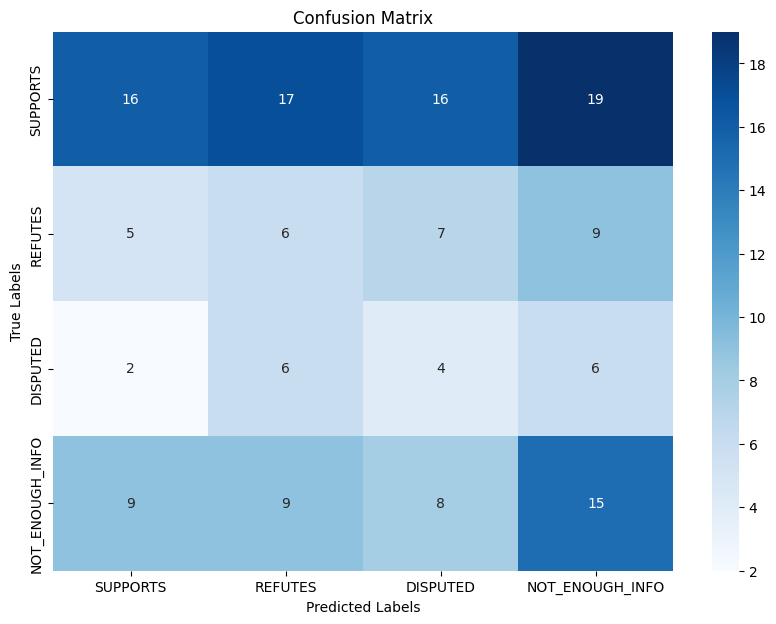

In [ ]:

def baseline():
    labels = ["SUPPORTS", "REFUTES", "DISPUTED", "NOT_ENOUGH_INFO"]
    return random.choice(labels)

predictions = []
for _ in range(dev_data.shape[0]):
    predictions.append(baseline())
    
actual_labels = dev_data['claim_label']

# Evaluate the performance
accuracy = accuracy_score(actual_labels, predictions)
report = classification_report(actual_labels, predictions)
conf_matrix = confusion_matrix(actual_labels, predictions, labels=["SUPPORTS", "REFUTES", "DISPUTED", "NOT_ENOUGH_INFO"])

# Print the evaluation results
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["SUPPORTS", "REFUTES", "DISPUTED", "NOT_ENOUGH_INFO"], yticklabels=["SUPPORTS", "REFUTES", "DISPUTED", "NOT_ENOUGH_INFO"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Classification Evaluation

In [ ]:
def evaluate(model, input, out):
    lst = []
    pred = []
    start = 0
    batch_size = 50
    in_len = len(input[0])
    model.eval()
    correct_count = 0
    while start < len(out):
        end = min(start+ batch_size, len(out))

        model_input = torch.LongTensor(input[start:end]).view(-1, in_len).cuda()

        model_output = model(model_input)
        model_output = torch.argmax(model_output, 1).tolist()
        pred.extend(model_output)
        for i, j in zip(model_output, out[start: end]):
            if i == j:
                correct_count += 1

        start = end
    lst = correct_count / len(out)
    print("\n")
    print("Classification Accuracy: %.3f" % lst)
    print("\n")

    model.train()
    return lst, pred

def predict( input, model):
    lst = []
    start = 0
    batch_size = 50
    in_len = len(input[0])
    model.eval()

    
    
    while start < len(input):
        end = min(start+ batch_size, len(input))
        
        model_input= torch.LongTensor(input[start:end]).view(-1, in_len).cuda()
        
        model_output = model(model_input)
        model_output = torch.argmax(model_output, 1).tolist()
        lst.extend(model_output)
        
        start = end

    return lst

In [ ]:

epochs = 10
m = 0
for epoch in range(epochs):
  loss = 0
  train()
  
  acc, pred= evaluate(classification_model, dev_in, dev_label)
  if acc > m:
    m = acc
    m_pred= pred




Classification Accuracy: 0.383




Classification Accuracy: 0.396




Classification Accuracy: 0.383




Classification Accuracy: 0.390




Classification Accuracy: 0.422




Classification Accuracy: 0.409




Classification Accuracy: 0.416




Classification Accuracy: 0.429




Classification Accuracy: 0.435




Classification Accuracy: 0.442




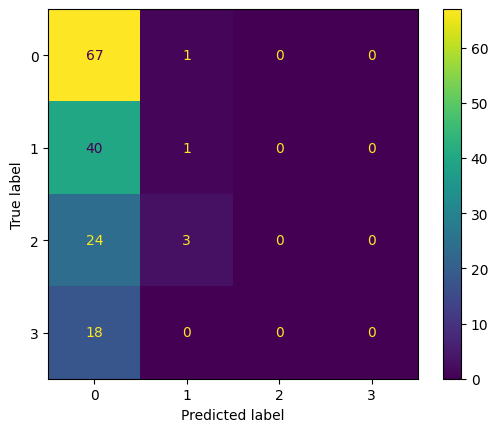

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(dev_label, m_pred)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
print(classification_report(dev_label, pred, labels=[0,1,2,3]))

              precision    recall  f1-score   support

           0       0.45      0.99      0.62        68
           1       0.20      0.02      0.04        41
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        18

    accuracy                           0.44       154
   macro avg       0.16      0.25      0.17       154
weighted avg       0.25      0.44      0.28       154



g:\Ana\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Ana\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\Ana\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
filtered_claim_evidences["pro_evidences"] = filtered_claim_evidences["evidences"].apply(lambda x:  [evidence_pd.iloc[int(re.sub("[^0-9]", "", i))]["pro_evidence"] for i in x])

In [ ]:
filtered_claim_evidences

,text,evidences,claim_label,pro_evidences
claim-752,south australia expensive electricity world,[evidence-421845],not there yet,[electricity company electricity trust]
claim-375,per cent total annual global emission carbon d...,[evidence-1140012],not there yet,[developing country highest rate woman cut som...
claim-1266,mean world warmer time,[evidence-694262],not there yet,[planet c warmer preindustrial time]
claim-871,happens zika may also good model second worryi...,[evidence-336512],not there yet,[research encompasses sexuallytransmitted dise...
claim-2164,greenland lost tiny fraction ice mass,[evidence-962481],not there yet,[tiny fraction original chemical energy used w...
...,...,...,...,...
claim-2400,suddenly label pollutant disservice gas played...,[evidence-885542],not there yet,[wonderful life]
claim-204,natural orbitally driven warming atmospheric c...,[evidence-617501],not there yet,[atmospheric carbon dioxide contains]
claim-1426,many world coral reef already barren state con...,[evidence-580567],not there yet,[coral reef system decline worldwide]
claim-698,recent study led lawrence livermore national l...,[evidence-366949],not there yet,[climate model include different external forc...


In [ ]:
filtered_claim_evidences
test_vec = wordtointvec(test["pro_claim_text"],token2id)
test_in = addpadding(34, test_vec, token2id)
test_evi_vec = wordtointvec4evi(filtered_claim_evidences['pro_evidences'],token2id)
max_len = 280
for i in range(len(test_in)):
  for j in test_evi_vec[i]:
    test_in[i].append(token2id["<sep>"])
    test_in[i].extend(j)
  test_in[i].append(token2id["<sep>"])
  if len(test_in[i]) < max_len:

    test_in[i].extend([token2id["<pad>"]] * (max_len - len(test_in[i])))

print(test_in[0])

[1, 2800, 1935, 713, 21, 121, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 904, 907, 904, 4506, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
test_classes = predict(test_in, classification_model)

In [ ]:
test_label = []
for i in test_classes:
    test_label.append(id2label[i])
test_label

['SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',
 'SUPPORTS',

In [ ]:
len(test_label)

153

In [ ]:
codalab = pd.DataFrame()
codalab["claim_text"] = test["claim_text"]
codalab["claim_label"] = test_label
codalab["evidences"] =filtered_claim_evidences["evidences"]
codalab

,claim_text,claim_label,evidences
claim-2967,The contribution of waste heat to the global c...,SUPPORTS,NaN
claim-979,“Warm weather worsened the most recent five-ye...,SUPPORTS,NaN
claim-1609,Greenland has only lost a tiny fraction of its...,SUPPORTS,NaN
claim-1020,“The global reef crisis does not necessarily m...,SUPPORTS,NaN
claim-2599,Small amounts of very active substances can ca...,SUPPORTS,NaN
...,...,...,...
claim-293,When the measuring equipment gets old and need...,SUPPORTS,NaN
claim-910,"The cement, iron and steel, and petroleum refi...",SUPPORTS,NaN
claim-2815,A new peer-reviewed study on Surface Warming a...,SUPPORTS,NaN
claim-1652,The strong CO2 effect has been observed by man...,SUPPORTS,NaN


In [ ]:

codalab.to_json("test-output.json",orient='index')


## Object Oriented Programming codes here

*You can use multiple code snippets. Just add more if needed*

In [ ]:

############# EFFECTIVELY OBSOLETE CODE FOR Word2Vec Embedding Generation in cells below ###########

import time
from multiprocessing.pool import ThreadPool
import pickle
import logging
from datetime import datetime

# Barely speeds up running time if at all???
# Thank GIL :c definitely not I/O bound
N_THREADS = 2

LOAD_FILES = True
# Logging setup
LOGGING = True
if LOGGING:
    log_filename = datetime.now().strftime("%m-%d_%H-%M") + "_logfile.log"
    logging.basicConfig(filename=log_filename,
                        format='%(asctime)s %(levelname)-8s %(message)s',
                        level=logging.INFO,
                        datefmt='%Y-%m-%d %H:%M:%S')




################################### BEGIN EVIDENCE PREP #####################################################
from gensim.utils import deaccent
from nltk import pos_tag
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer

import re
import time

import pandas as pd
import json

import pickle
import nltk
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

# contraction_dict from WS7
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have",
                    "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                    "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                    "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                    "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                    "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                    "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                    "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                    "so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                    "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                    "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have",
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                    "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                    "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                    "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}


# https://stackoverflow.com/a/46231553
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 


def sentence_preprocessing(sentence):

    out_list = []
    # Use gensim deaccent to match more characters to [a-z]
    sentence = deaccent(sentence.lower())

    for old, new in contraction_dict.items():
        sentence.replace(old, new)

    tokenized = word_tokenize(sentence)

    # now remove all tokens that don't contain any alphanumeric characters
    # then strip non alphanumeric characters afterwards
    tokenized = [re.sub(r"[^a-z0-9\s]", "", token) for token in tokenized if re.match(r"[a-z0-9\s]", token)]

    # now lemmatize with pos
    tagged = pos_tag(tokenized)
    for token, tag in tagged:
        wntag = get_wordnet_pos(tag)

        if wntag is None: # do not supply tag in case of None
            lemma = lemmatizer.lemmatize(token) 
        else:
            lemma = lemmatizer.lemmatize(token, pos=wntag) 

        out_list.append(lemma)
    
    return out_list


def evidence_preprocessing(evidences):
  t = time.time()
  processed = []
  for index, item in enumerate(evidences.items()):
    id, evidence = item

    row = []
    
    row.append(id)
    row.append(evidence)

    # break the text into sentences before tokenizing by each sentence
    processed_sentences = [sentence_preprocessing(sentence) for sentence in sent_tokenize(evidence)]
    row.append(processed_sentences)


    # Appending an empty list to populate with embeddings later
    row.append([])

    processed.append(row)

    if (index + 1) % 50000 == 0:
        print(f"{time.time() - t:.2f} - {index+1} rows processed")

  return pd.DataFrame(processed, columns = ["id", "raw evidence", "processed evidence", "embeddings"])



#### LOCATE EVIDENCE FILE HERE ####

if LOAD_FILES:
    with open("evidence_preprocessed_bert_v3.pkl","rb") as f:
        evidence = pickle.load(f)
        if LOGGING:
            logging.info("evidence loaded")
else:
    d_evidence = pd.read_json("data/evidence.json", typ='series')
    evidence = evidence_preprocessing(d_evidence)
    with open("evidence_preprocessed_bert_v3.pkl","wb") as f:
        pickle.dump(evidence, f)

###### END EVIDENCE PREP #####################################################################

MAKE_CHECKPOINT = False

# Surprisingly couldn't find an implementation on torch/tf/keras
# Byte Pair Encoding tokenizer
# Some sections referenced from 
# https://martinlwx.github.io/en/the-bpe-tokenizer/
class BPE:
    def __init__(self, corpus, vocab_size, min_count=1):
        self.corpus = corpus
        self.vocab_size = vocab_size
        self.min_count = min_count
        
        self.vocab = []
        
        self.word_freq = {}
        
        # For multiprocessing only
        # Copy of word frequency dict split into equal sized partitions
        self.word_freq_partitions = [{} for _ in range(N_THREADS)]
        
        # word to fragments
        self.word_partitions = {}
        
        # fragments to bigger fragments
        self.merge_rules = {}


    def train(self):

        t_start = time.time()
        for paragraph in self.corpus:
            for sentence in paragraph:
                i = 0
                for word in sentence:
                    self.word_freq[word] = self.word_freq.get(word, 0) + 1
                    self.word_freq_partitions[i % N_THREADS][word] = self.word_freq_partitions[i % N_THREADS].get(word, 0)+1
        
        alphabet = set()
        for word in self.word_freq:

            # initialize word partitions
            char_list = list(word)
            char_list = ["##" + char_list[i] if i != 0 else char_list[0] for i in range(len(char_list))]
            self.word_partitions[word] = char_list

            # construct alphabet
            # misnomer possibly since plenty of tokens will have the ## prefix
            for letter in word:
               if letter not in alphabet:
                   alphabet.add(letter)

        self.vocab = list(alphabet)
        self.vocab.sort()

        print(f"Time {time.time()-t_start:.2f} - Alphabet initialized with size {len(alphabet)}.")
        print(f"Alphabet: {self.vocab}")

        if LOGGING:
            logging.info(f"Alphabet constructed. Size: {len(alphabet)}")

        
        # 05/07: Any chance of multithreading part of this somehow?
        # 05/13: No.
        iter = 0
        while len(self.vocab) < self.vocab_size:

            #t_s = time.time()
            # ~4s singlethread

            # TODO_done: Change most frequent to WordPiece
            # WordPiece scaling applied here already
            pair_freq = self.get_pair_freq(wordpiece=True)

            #print(f"pair_freq: {time.time()-t_s:.2f}s")
            

            if len(pair_freq) == 0:
                print(f"Time {time.time()-t_start:.2f} - No more pairs. Exiting at vocab size {len(self.vocab)}")

            
            # Gets the pair that appears most in the training set
            
            best_pair = max(pair_freq, key=pair_freq.get)

            #t_s = time.time()
            # ~3s singlethread
            self.update_word_partitions(best_pair[0], best_pair[1])
            
            
            #print(f"update_word_partitions: {time.time()-t_s:.2f}s")

            # practically instant
            self.merge_rules[best_pair] = best_pair[0] + best_pair[1][2:]
            self.vocab.append(best_pair[0] + best_pair[1][2:])

            if LOGGING:
                logging.info(f"{str.rjust(best_pair[0], 10)} + {str.rjust(best_pair[1], 10)} => {str.rjust(best_pair[0]+best_pair[1][2:], 10)}")
            # Sanity keeping every 100 iterations - whole loop takes --HOURS-- nevermind DAYS
            iter += 1
            if iter % 100 == 0:
                print(f"Time {time.time()-t_start:.2f} - Now on iteration {iter}.")
                if LOGGING:
                    logging.info(f"Iteration {iter} completed.")

            # Save a checkpoint every 1000 iterations
            if MAKE_CHECKPOINT and iter % 1000 == 0:
                self.save()
        self.save()


    # Returns a pair frequency dictionary with entries:
    # pair (tuple) : freq (int)
    def get_pair_freq(self, wordpiece = True):
        pair_freq = {}
        singleton_freq = {}

        #pair_freq_partitions = []

        # Multithreading attempt
        # Doesn't work I think.. not enough compute time on colab either
        pool = ThreadPool(N_THREADS)

        def get_pair_freq_subtask(partition):

            #pair_freq_partition = {}

            for word_freq_pair in partition.items():
                word, freq = word_freq_pair
                word_partition = self.word_partitions[word]

                for i in range(len(word_partition)-1):
                    #pair_freq_partition[(word_partition[i], word_partition[i+1])] = pair_freq_partition.get((word_partition[i], word_partition[i+1]), 0) + freq
                    pair_freq[(word_partition[i], word_partition[i+1])] = pair_freq.get((word_partition[i], word_partition[i+1]), 0) + freq
                    singleton_freq[word_partition[i]] = singleton_freq.get(word_partition[i],0) + freq
                
                singleton_freq[word_partition[len(word_partition)-1]] = singleton_freq.get(word_partition[len(word_partition)-1],0) + freq
            return

        # returns None, results are already aggregated by the time all threads join.
        pool.map(get_pair_freq_subtask, self.word_freq_partitions)

        # WordPiece scaling, divide all pair frequency scores by product of singleton scores
        if wordpiece:
            for pair, freq in pair_freq.items():
                freq = freq/singleton_freq.get(pair[0])
                freq = freq/singleton_freq.get(pair[1])

        return pair_freq


    # Merge word partitions by the new pattern
    # Modify in place for performance (saves ~0.2s/iter)
    def update_word_partitions(self, left, right):
        

        # Supposedly jank if using .items() and modifying in place so this will do
        # https://stackoverflow.com/a/6777569
        for word in self.word_partitions.keys():

            partition = self.word_partitions[word]
            length = len(partition)

            i = 0
            while i < length:
                
                # Last token, do nothing
                if i+1 >= length:
                    pass
                
                # Else check for matching pattern
                # Delete the next entry if matches
                elif partition[i] == left and partition[i+1] == right:

                    # WordPiece specific: get rid of the ## prefix on right
                    partition[i] = partition[i] + partition[i+1][2:]
                    
                    del partition[i+1]
                    length -= 1 # Otherwise runs out of bounds
    
                i += 1

    def save(self, path=""):
        VERSION = 1.5
        # Save to a model to be reused later
        with open(f"{path}BPETokenizer_partitions_v{VERSION}.pkl", "wb") as partitions,\
            open(f"{path}BPETokenizer_merge_rules_v{VERSION}.pkl", "wb") as merge_rules:
            
            # Only need these two, can reuse corpus to continue training
            pickle.dump(self.word_partitions, partitions)
            pickle.dump(self.merge_rules, merge_rules)



In [ ]:
if LOAD_FILES:
    with open("BPETokenizer_merge_rules_v1.5.pkl", "rb") as f:
        merge_rules = pickle.load(f)
else:
    bpe = BPE(evidence.loc[:,"processed evidence"], 20000, min_count=4)

    # Up to 4 days on jupyter... about 2 days offline
    bpe.train()

    VERSION = 1.6
    with open(f"BPETokenizer_partitions_v{VERSION}.pkl", "wb") as partitions,\
        open(f"BPETokenizer_merge_rules_v{VERSION}.pkl", "wb") as merge_rules:
        pickle.dump(bpe.word_partitions, partitions)
        pickle.dump(bpe.merge_rules, merge_rules)

    merge_rules = bpe.merge_rules

In [ ]:
################# ALL CODE IN THIS CELL AND BELOW ARE EFFECTIVELY OBSOLETE #################

######## WordPiece tokenizer ###########

# https://huggingface.co/learn/nlp-course/chapter6/6
def encode_word(word):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

# adapted from https://huggingface.co/learn/nlp-course/chapter6/6
def tokenize(sentence):
    sentence = sentence_preprocessing(sentence)
    encoded_words = [encode_word(word) for word in sentence]
    return sum(encoded_words, [])


# Reconstruct vocab from merge rules due to lack of foresight
# This grabs all vocab of length 2 or above (if contains first letter)
# or 4 or above (##__)
vocab = [v for v in merge_rules.values()]

# So iterate through merge rules again to find starting letters
# and one letter suffixes
for pair, merge in merge_rules.items():
    if len(pair[0]) == 1 and pair[0] not in vocab:
        vocab.append(pair[0])
    if len(pair[1]) == 3 and pair[1] not in vocab:
        vocab.append(pair[1])




counter = 0
def processed_evidence_to_bpe(paragraph):

    # super ugly global var for progress and speed tracking 
    # spoiler alert: VERY VERY slow
    global counter
    counter += 1
    if counter % 1000 == 0:
        print(f"{counter} rows processed")
    #2d array -> paragraph
    if type(paragraph[0]) is list:
        return [tokenize(sentence) for sentence in paragraph]

    # 1 sentence -> tokenize as is 
    else:
        return tokenize(paragraph)
    

##################### BPE WordPiece Tokenize Evidence ########################

if LOAD_FILES:
    with open("BPETokenized_evidence_v3.pkl", "rb") as f:
        evidence = pickle.load(f)
else:
    evidence["bpe evidence"] = evidence["processed evidence"].apply(processed_evidence_to_bpe)
    with open("BPETokenized_evidence_v3.pkl", "wb") as f:
        pickle.dump(evidence, f)

# Now do word2vec
from gensim.models import Word2Vec


EMBEDDING_DIM = 200


"""
# Collect sentences from tokenized paragraphs
sentences = []

for paragraph in evidence["bpe evidence"]:
    if type(paragraph[0]) is list:
        # paragraph with multiple sentences
        for sentence in paragraph:
            sentences.append(sentence)
    else:
        # paragraph with one sentence, append directly
        sentences.append(paragraph)

###### HYPERPARAMETER EXPLORATION LOOP DELETED #########
embedding_model = Word2Vec(sentences=sentences,
                           vector_size=EMBEDDING_DIM,
                           window=4,
                           min_count=3,
                           workers=10,
                           negative=5
                           )

version = 3
with open(f"embeddings_BPE_v{version}.pkl", "wb") as f:
    pickle.dump(embedding_model, f)


# Embedding helpers to get sentence/paragraph embeddings
def sentence_embedding(sentence):

  # Failsafe
  if len(sentence) == 0:
    return np.zeros(EMBEDDING_DIM)

  if type(sentence[0]) is not list:
      sentence = tokenize(sentence)


  embedding = np.zeros(EMBEDDING_DIM)
  for word in sentence:
    word_embedding = np.zeros(EMBEDDING_DIM)

    # get word vector for given word
    # if not found, ignore (treat as having the zero vector)
    try:
      word_embedding = embedding_model.wv[str(word)]
    except KeyError:
      pass

    embedding += word_embedding

  return embedding / len(sentence)


def paragraph_embedding(paragraph):
    out = []

    # One sentence
    if type(paragraph[0]) is not list:
        return [sentence_embedding(paragraph)]

    else:
        for sentence in paragraph:
            out.append(sentence_embedding(sentence))
    return out
"""